# ICU Length of Stay (LOS) Prediction – MIMIC-III Data (Improved Version)

This is an assignment notebook for AI in Healthcare at University of Texas at Austin.
This notebook predicts whether an ICU patient's length of stay (LOS) exceeds 3 days using the **MIMIC-III clinical dataset**.

Owner: Caroline N. El Jazmi


### **New Improvements**
1. **More Predictive Features:**
   - Comorbidities count (from `DIAGNOSES_ICD.csv`)
   - Admission type (emergency vs elective) from `ADMISSIONS.csv`
2. **Hyperparameter tuning (RandomizedSearchCV) for Random Forest**
3. **Model sweep updated to include tuned models**
4. **Better feature scaling and encoding**

These enhancements aim to improve model discrimination (AUC) and reduce reliance on age alone.


In [1]:

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import accuracy_score, roc_auc_score
from scipy.stats import randint
import matplotlib.pyplot as plt

try:
    from xgboost import XGBClassifier
    xgboost_available = True
except ImportError:
    xgboost_available = False

from tqdm import tqdm

In [8]:

# ================================
# 1. LOAD REQUIRED MIMIC-III TABLES
# ================================
ICU_STAYS = "MIMIC-Dataset/ICUSTAYS.csv"
PATIENTS = "MIMIC-Dataset/PATIENTS.csv"
ADMISSIONS = "MIMIC-Dataset/ADMISSIONS.csv"
DIAGNOSES_ICD = "MIMIC-Dataset/DIAGNOSES_ICD.csv"
diagnoses = pd.read_csv(DIAGNOSES_ICD)
icustays = pd.read_csv(ICU_STAYS)
patients = pd.read_csv(PATIENTS)
admissions = pd.read_csv(ADMISSIONS)


# Ensure SUBJECT_IDs are integers
for df_check in [icustays, patients, admissions, diagnoses]:
    df_check["SUBJECT_ID"] = df_check["SUBJECT_ID"].astype(int)

# ================================
# 2. CREATE COMORBIDITY FEATURE
# ================================
comorbidities = diagnoses.groupby("HADM_ID")["ICD9_CODE"].nunique().reset_index()
comorbidities.columns = ["HADM_ID", "COMORBIDITY_COUNT"]

# Merge ICU + patient + admission + comorbidities
df = icustays.merge(patients, on="SUBJECT_ID", how="left")
df = df.merge(admissions[["SUBJECT_ID","HADM_ID","ADMISSION_TYPE"]], on=["SUBJECT_ID","HADM_ID"], how="left")
df = df.merge(comorbidities, on="HADM_ID", how="left")
df["COMORBIDITY_COUNT"] = df["COMORBIDITY_COUNT"].fillna(0)

# Convert to datetime
df["INTIME"] = pd.to_datetime(df["INTIME"], errors="coerce")
df["DOB"] = pd.to_datetime(df["DOB"], errors="coerce")

# ================================
# SAFE AGE CALCULATION (ROW-BY-ROW)
# ================================
def calculate_age(row):
    try:
        if pd.isna(row["DOB"]) or pd.isna(row["INTIME"]):
            return np.nan
        age = (row["INTIME"] - row["DOB"]).days / 365.25
        if age < 0 or age > 120:
            return 90
        if age > 89:
            return 90
        return age
    except:
        return 90

df["AGE"] = df.apply(calculate_age, axis=1)

# ================================
# WEEKEND ADMISSION FLAG
# ================================
admissions["ADMITTIME"] = pd.to_datetime(admissions["ADMITTIME"], errors="coerce")
admissions["WEEKEND_ADMISSION"] = admissions["ADMITTIME"].dt.dayofweek >= 5
df = df.merge(admissions[["SUBJECT_ID", "WEEKEND_ADMISSION"]], on="SUBJECT_ID", how="left")

# Final dataset
df = df[["AGE","GENDER","FIRST_CAREUNIT","LOS","WEEKEND_ADMISSION","ADMISSION_TYPE","COMORBIDITY_COUNT"]].dropna()
print("Final dataset shape:", df.shape)
df.head()


Final dataset shape: (116414, 7)


,AGE,GENDER,FIRST_CAREUNIT,LOS,WEEKEND_ADMISSION,ADMISSION_TYPE,COMORBIDITY_COUNT
0,65.982204,F,MICU,3.2490,True,EMERGENCY,9
1,40.098563,M,MICU,3.2788,False,EMERGENCY,9
2,80.076660,M,CCU,2.8939,False,ELECTIVE,9
3,45.683778,F,MICU,2.0600,False,EMERGENCY,5
4,67.093771,M,CCU,1.6202,False,EMERGENCY,7


In [4]:

# ================================
# 2. FEATURE ENGINEERING
# ================================

# Binary LOS target (>3 days = 1)
df["LOS_BINARY"] = (df["LOS"] > 3).astype(int)

# Age groups
df["AGE_GROUP"] = pd.cut(df["AGE"], bins=[0,40,65,120], labels=["young","adult","elderly"])

# Critical care flag
df["CRITICAL_CARE_UNIT"] = df["FIRST_CAREUNIT"].isin(["MICU","CCU"]).astype(int)

# Emergency admission flag
df["EMERGENCY_ADMISSION"] = df["ADMISSION_TYPE"].str.contains("EMERGENCY", case=False).astype(int)

# Encode categorical variables
le_gender = LabelEncoder()
le_agegroup = LabelEncoder()

df["GENDER_ENCODED"] = le_gender.fit_transform(df["GENDER"])
df["AGE_GROUP_ENCODED"] = le_agegroup.fit_transform(df["AGE_GROUP"])

# Features
features = ["AGE","GENDER_ENCODED","AGE_GROUP_ENCODED","CRITICAL_CARE_UNIT",
            "WEEKEND_ADMISSION","EMERGENCY_ADMISSION","COMORBIDITY_COUNT"]

X = df[features]
y = df["LOS_BINARY"]

# Scale continuous features
scaler = StandardScaler()
X_scaled = X.copy()
X_scaled[["AGE","COMORBIDITY_COUNT"]] = scaler.fit_transform(X[["AGE","COMORBIDITY_COUNT"]])


In [7]:

# ================================
# 3. MODEL TRAINING WITH HYPERPARAMETER TUNING & SWEEP
# ================================

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

models = {
    "Logistic Regression": LogisticRegression(max_iter=1000, verbose=1),
    "Gradient Boosting": GradientBoostingClassifier()
}

if xgboost_available:
    models["XGBoost"] = XGBClassifier(use_label_encoder=False, eval_metric="logloss", verbosity=1)

# Hyperparameter tuning for Random Forest
rf_param_grid = {
    "n_estimators": randint(50, 200),
    "max_depth": randint(3, 15),
    "min_samples_split": randint(2, 10)
}
rf_random = RandomizedSearchCV(RandomForestClassifier(random_state=42), rf_param_grid,
                               n_iter=10, cv=3, scoring="roc_auc", random_state=42, verbose=1)
models["Random Forest (Tuned)"] = rf_random

results = []
print("Training models with logging...")

for name, model in models.items():
    print(f"▶ Training {name}...")
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    y_proba = model.predict_proba(X_test)[:,1]
    acc = accuracy_score(y_test, y_pred)
    auc = roc_auc_score(y_test, y_proba)
    results.append([name, acc, auc])

results_df = pd.DataFrame(results, columns=["Model","Accuracy","AUC"]).sort_values(by="AUC", ascending=False)
print("\nModel Performance Comparison:")
print(results_df)


Training models with logging...
▶ Training Logistic Regression...
▶ Training Gradient Boosting...


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s finished


▶ Training Random Forest (Tuned)...
Fitting 3 folds for each of 10 candidates, totalling 30 fits

Model Performance Comparison:
                   Model  Accuracy       AUC
2  Random Forest (Tuned)  0.717734  0.766288
1      Gradient Boosting  0.668471  0.695198
0    Logistic Regression  0.643817  0.624581


Best Model: Random Forest (Tuned)


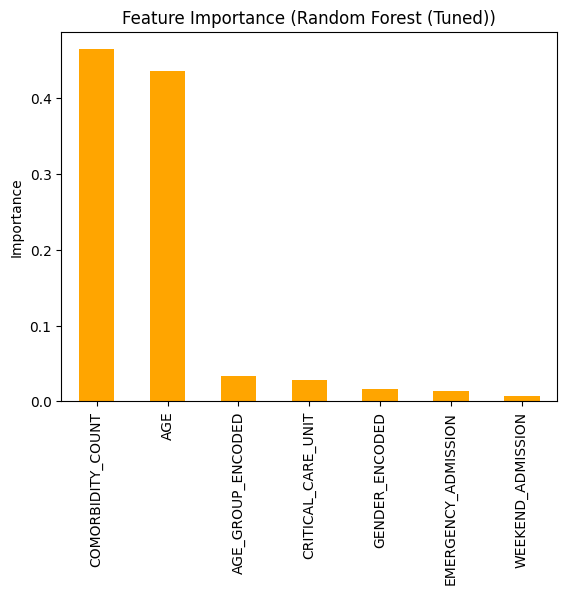

In [9]:
# ================================
# 4. FEATURE IMPORTANCE (BEST MODEL)
# ================================

best_model_name = results_df.iloc[0]["Model"]
print(f"Best Model: {best_model_name}")

if "Random Forest" in best_model_name:
    best_rf = models["Random Forest (Tuned)"].best_estimator_
    importances = pd.Series(best_rf.feature_importances_, index=features).sort_values(ascending=False)
elif best_model_name == "Gradient Boosting":
    importances = pd.Series(models["Gradient Boosting"].feature_importances_, index=features).sort_values(ascending=False)
elif best_model_name == "XGBoost" and xgboost_available:
    importances = pd.Series(models["XGBoost"].feature_importances_, index=features).sort_values(ascending=False)
else:
    importances = None

if importances is not None:
    importances.plot(kind="bar", color="orange")
    plt.title(f"Feature Importance ({best_model_name})")
    plt.ylabel("Importance")
    plt.show()


In [10]:

# ================================
# 5. CONCLUSION
# ================================
if importances is not None:
    top_feature = importances.idxmax()
    print(f"Top Predictor of ICU LOS >3 days: {top_feature}")
else:
    print("Logistic Regression chosen – feature importance not plotted.")


Top Predictor of ICU LOS >3 days: COMORBIDITY_COUNT
